In [1]:
import ray
import os

In [2]:
#To insert our working directory
import sys 
sys.path.insert(0, 'E:\\Machine_Learning_Projects\\madewithml\\Made_with_ML_project\\')
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-01-05 09:23:55,310	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'node:127.0.0.1': 1.0,
 'object_store_memory': 1146995097.0,
 'memory': 2293990196.0,
 'CPU': 16.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 7, "GPU": 1}

In [6]:
# Storage
EFS_DIR = f"/efs/shared_storage/madewithml/arunkumargudla"
print (EFS_DIR)

/efs/shared_storage/madewithml/arunkumargudla


## Data Ingestion 

In [7]:
import pandas as pd

In [8]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## Data splitting

Ideally we will divide data into train and test split

Train set will be further divided into train and holdout set for validation (keep in mind of equal distribution of labels so stratify)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [11]:
# splitting dataset

test_size = 0.2 
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
#checking train counts of labels 

train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [13]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

## Exploratory Data Analysis 

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [15]:
# most common tags 
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

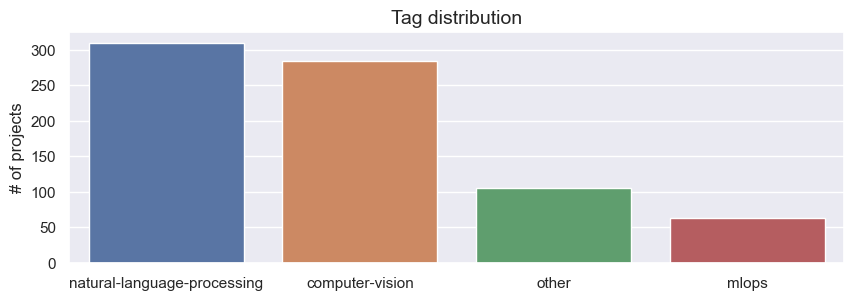

In [16]:
# plot tag frequenices

tag, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tag), y=list(tag_counts))
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

### Word CLoud visualization

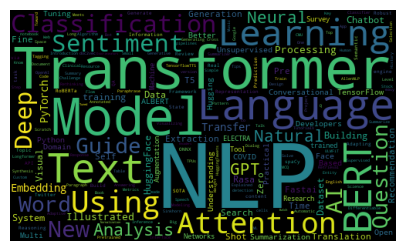

In [17]:
#looking at word cloud distribution for each tag based on title feature

tag = 'natural-language-processing'
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

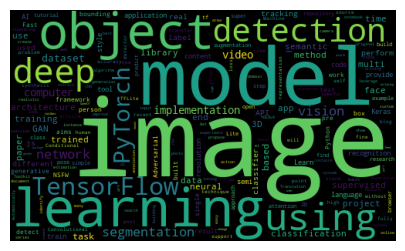

In [18]:
#looking at word cloud distribution for each tag based on description feature

tag = 'computer-vision'
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.description.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Data PreProcessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [19]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [20]:
# combining title and description (it could be or not a meaningful feature)

df["text"] = df.title + " " + df.description

In [21]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [23]:
# applying on df 

original_df = df.copy()
df.text = df.text.apply(clean_text)
print((f"{original_df.text.values[0]}\n{df.text.values[0]}"))

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [24]:
# DataFrame cleanup

df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [25]:
df.shape

(764, 2)

### Encoding

In [26]:
# converting labels into numbers 

tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [27]:
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [28]:
# decoding back the labels to classes 

def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [29]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [30]:
# encoding the text feature

import numpy as np
from transformers import BertTokenizer

In [31]:
# Initializing Bert tokenizer (explanation)

tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")

print("input_ids:", encoded_inputs["input_ids"])
print("attention_mask:", encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [32]:
encoded_inputs

{'input_ids': array([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,
          103]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [33]:
# creating a function 

def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [34]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2], dtype=int64)}

In [35]:
# applying all the preprocessing in single function 

def preprocess(df, class_to_index):
    """
    pre preprocess the given dataframe
    """
    
    df["text"] = df.title + " " + df.description  # feature engineering 
    df["text"] = df["text"].apply(clean_text)
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [36]:
# applying to train df 
preprocess(train_df, class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

## Distributed Processing 

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [37]:
from ml_scripts.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

> The only setup we have to do is set Ray to preserve order when acting on our data. This is important for ensuring reproducible and deterministic results.

In [38]:
# data ingestion using Ray Data 

ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-01-05 09:24:15,390	INFO read_api.py:406 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2024-01-05 09:24:15,417	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-01-05 09:24:15,419	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:24:15,420	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:15,421	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 733,
  'created_on': datetime.datetime(2020, 5, 6, 4, 30, 47),
  'title': 'LandCover.ai',
  'description': 'Dataset for automatic mapping of buildings, woodlands and water from aerial imagery.',
  'tag': 'computer-vision'}]

In [39]:
 # Split dataset using Ray's tarin test

test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-05 09:24:17,500	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:24:17,500	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:17,501	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# preprocessing using Ray 

tags = train_ds.unique(column='tag')
class_to_index = {tag: i for i, tag in enumerate(tags)}


2024-01-05 09:24:18,104	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:24:18,105	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:18,105	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:24:19,975	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-01-05 09:24:19,977	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:19,980	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [41]:
# Distributed preprocessing 

sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2024-01-05 09:24:21,342	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-01-05 09:24:21,343	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:21,344	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

{'ids': array([  102,  3928,   255,  1861, 30138, 30118,  5702,  2112,   255,
        2641,  4631,  1904,  1313, 15095,   103,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training Setup (Fine Tuning an LLM model)

We'll start by defining some setup utilities and configuring our model.

We'll define a set_seeds function that will set the seeds for reproducibility across our libraries (`np.random.seed, random.seed, torch.manual_seed and torch.cuda.manual_seed`). We'll also set the behavior for some torch backends to ensure deterministic results when we run our workloads on GPUs.

In [42]:
import os 
import random
import torch
from ray.data.preprocessor import Preprocessor

In [43]:
# setting a common seed for reproducibility across whole process and deterministic True indicates same results are produced

def set_seeds(seed=42):
    """
    Set seed for reproducibility
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

> Loading function to load the dataset using Ray Dataset

In [44]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    
    # to return sampled dataset if required
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

> When working with very large datasets, it's a good idea to limit the number of samples in our dataset so that we can execute our code quickly and iterate on bugs, etc. This is why we have a num_samples input argument in our load_data function (None = no limit, all samples).

Now we will define custom preprocessor function with Ray's Preprocessor as base function. This will have fit method and transfrom_pandas method since our preprocess function expects batch of data as pandas dataframe.

In [45]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

### Model training 

Using an pre trained SciBert model from Hugging face library

In [46]:
import torch.nn as nn
from transformers import BertModel
import torch.nn.functional as F

In [47]:
# loading our pre trained llm model (uncased - only lower case)

llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size 

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
# each word or sentence is represented in 768 dimensionsal vector embeddings
embedding_dim

768

In [49]:
# tokenizing on sample data using above model 

text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k: torch.tensor(v) for k,v in batch.items()} # converting to torch tensor
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

We're going to use this pretrained model to represent our input text features and add additional layers (linear classifier) on top of it for our specific classification task. In short, the pretrained LLM will process the tokenized text and return a sequence (one representation after each token) and pooled (combined) representation of the text. We'll use the `pooled representation as input` to our final fully-connection layer (fc1) to result in a `vector of size num_classes (number of classes)`` that we can use to make predictions.

In [50]:
# fine tuning scibert model in pytorch framework

class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy() # returns indices with max prob value
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [51]:
# initializing the fine tuning model 

model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the single batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom collate_fn to repad the items in our training batches

In [52]:
from ray.train.torch import get_device

In [53]:
# defining func to pad the tokens and attention masks to the longest sequence length in whole traning set 

def pad_array(arr, dtype=np.int32):
    """ padding the array to longest sequence """
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    # filling zeros at the end of each item
    for i, row in  enumerate(arr):
        padded_arr[i][:len(row)] = row 
        
    return padded_arr
    

In [54]:
# function to pad zeros and convert into torch tensors (since the tokenizer returns numpy array)

def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
        
    return tensor_batch

In [55]:
# checking sample input 

sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-01-05 09:24:27,469	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-01-05 09:24:27,470	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:27,471	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

{'ids': tensor([[  102,  7746,  2824,  ...,     0,     0,     0],
         [  102,   191, 23495,  ...,     0,     0,     0],
         [  102,  6317, 21024,  ...,     0,     0,     0],
         ...,
         [  102, 15689,  6392,  ...,     0,     0,     0],
         [  102,  3840,  1984,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 2, 0, 2, 2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 0, 0, 3, 2, 0, 3, 2, 0, 2, 0,
         2, 2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 0, 0, 3, 2, 0, 3, 2, 3, 1, 3, 2, 2, 3,
         2, 1, 2, 2, 2, 2, 2, 3, 0, 3, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 3,
         2, 0, 3, 0, 2, 3, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 1,
         3, 2, 

## Utilities 

Implementing some utility functions to train the model like setting up Run Configuration, Scaling configuration etc

In [56]:
from ray.air import Checkpoint, session
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer, TorchConfig
import torch.nn.functional as F
from pathlib import Path
import tempfile
from torch.nn.parallel.distributed import DistributedDataParallel

We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a loss function, and an optimizer. It will then perform a forward pass, compute the loss, and perform a backward pass to update the model's weights. And finally, it will return the loss.

In [57]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """
    Training step to train a model and returns cumulative loss value
    """
    
    model.train()
    loss = 0.0 
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [58]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

Next, we'll define the train_loop_per_worker which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!

In [59]:

# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

> Defining required configurations to train the model 

In [60]:
# training loop config 

train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [61]:
# definig scaling configuration (using gpu and speaking cpu nodes across cluster)

scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
)

Next, we'll define our `CheckpointConfig` which will specify how we want to checkpoint our model. Here we will just save one checkpoint ``(num_to_keep)`` based on the checkpoint with the min val_loss. We'll also configure a `RunConfig` which will specify the name of our run and where we want to save our checkpoints.

In [62]:
from ml_scripts.config import EFS_DIR

In [63]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep= 1, checkpoint_score_attribute= "val_loss", checkpoint_score_order= "min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir=EFS_DIR)

## Training 

Now we are ready to train model on distributed setup with all above components 

Here we will load the dataset and do preprocessing before instead of doing it during training stage

In [64]:
# laod and split the dataset 

ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-05 09:24:30,337	INFO read_api.py:406 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2024-01-05 09:24:30,342	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:24:30,343	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:30,343	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
# preprocessing the loaded data 

preprocessor = CustomPreprocessor()
preprocessor =preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-01-05 09:24:30,765	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:24:30,766	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:30,766	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:24:31,531	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-01-05 09:24:31,534	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:31,534	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:24:32,528	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:24:32,529	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:32,530	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:24:33,992	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:24:33,993	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:33,993	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

> Calling materialize here is important because it will cache the preprocessed data in memory. This will allow us to train our model without having to reprocess the data each time. 

Because we've preprocessed the data prior to training, we can use the `fit=False` and `transform=False` flags in our dataset config. This will allow us to skip the preprocessing step during training using the configuration setup.

In [66]:
# dataset config 

# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

> Ray supports different trainer for different frameworks like Tensorflow, xgboost etc. In our case we will use TorchTrainer

In [67]:
# calling TorchTrainer with all defined configurations
torch_config = TorchConfig(backend="gloo")

trainer = TorchTrainer(
    train_loop_per_worker= train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    torch_config=torch_config,
    datasets={"train": train_ds, "val":val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index})

**To use gloo backend in pytorch as windows doesn't support NCCL backend**

In [68]:
# fitting our model to data 

#results = trainer.fit()

In [69]:
# checking the run results

#results.metrics_dataframe

In [70]:
# best checkpoint which has minimum validation loss

#results.best_checkpoints

### Evaluation 

Evaluating above model on sample validation dataset 

In [71]:
from sklearn.metrics import precision_recall_fscore_support

In [136]:
# defining torchPredcitor according to our use case

class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [73]:
# Artifacts
# best_checkpoint = results.best_checkpoints[0][0]
# predictor = TorchPredictor.from_checkpoint(best_checkpoint)
# preprocessor = predictor.get_preprocessor()

In [74]:
#results.best_checkpoints[0][0]

In [75]:
# resume the inference from saved checkpoint

# torch.save(best_checkpoint, 'checkpoint.pth')
checkpoint = torch.load( 'checkpoint.pth')

In [76]:
# Artifacts

predictor = TorchPredictor.from_checkpoint(checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
# loading holdout set 

HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2024-01-05 09:24:39,171	INFO read_api.py:406 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2024-01-05 09:24:39,176	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-01-05 09:24:39,178	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:39,179	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]),
  'targets': 3}]

In [78]:
# getting y_true value

values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item['targets'] for item in values])
print(y_true)

2024-01-05 09:24:40,052	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-01-05 09:24:40,054	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:40,054	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [79]:
# getting y_pred

predictions = preprocessed_ds.map_batches(predictor).take_all()


2024-01-05 09:24:41,111	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-01-05 09:24:41,112	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:24:41,113	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=6500) C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2252\1097317791.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)


In [80]:
y_pred = np.array([d["output"] for d in predictions])

In [81]:
# evaluating using precsion_recall score
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9339843154698659,
 'recall': 0.9319371727748691,
 'f1': 0.9312127413632342}

In [82]:
# putting all together in a single function 

def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor() # predcitor loaded from checkpoint
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [83]:
# Evaluate on test split
# performance = evaluate(ds=test_ds, predictor=predictor)
# print (json.dumps(performance, indent=2))

> The model is performing well with good recall, precision and f1 score 

## Inference 

Now we will try to get prediction probabilities for each label for a given input. Defining requried functions to do 

In [84]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item 
        
    return d

In [85]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results


In [86]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2024-01-05 09:25:40,392	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-05 09:25:40,393	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:40,393	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00013394534,
   'mlops': 0.00021020895,
   'natural-language-processing': 0.99945337,
   'other': 0.00020245658}}]

## Experiment Tracking

Experiment tracking is the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

* Organize all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
* Reproduce past results (easily) using saved experiments.
* Log iterative improvements across time, data, ideas, teams, etc.

here are many options for experiment tracking but we're going to use MLFlow (100% free and open-source) because it has all the functionality we'll need. We can run MLFlow on our own servers and databases so there are no storage cost / limitations, making it one of the most popular options and is used by Microsoft, Facebook, Databricks and others.

In [87]:
import mlflow 
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

Creating a path to store all mlruns (both artifact & backend store) in a local directory for our project purpose. Generally in `production setting`, artifacts store will be cloud (ex: s3) and backend store will be any database server(eg: postgres)

In [88]:
# configuring mlflow and setting mlflow tracking uri

MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file:///" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(mlflow.get_tracking_uri())

file:///E:\efs\shared_storage\madewithml\mlflow


> Adding mlflow to training api using Ray is easy, we just need to add it as a callback since the Ray has mlflow integrations, it automatically logs all the required components in an experiement 

In [89]:
# adding mlflow callback 

#experiment_name = f"llm-{int(time.time())}"
experiment_name = "llm-1704277824"
mlflow_callback = MLflowLoggerCallback(
tracking_uri= MLFLOW_TRACKING_URI,
experiment_name=experiment_name,
save_artifact=True)

In [90]:
# updating Torch Run configuration with mflow callback 

# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

> Training the model again with mlflow setup, so the experiment can be tracked visually

In [91]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-05 09:25:45,840	INFO read_api.py:406 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2024-01-05 09:25:45,857	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:25:45,857	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:45,858	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-01-05 09:25:46,381	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:25:46,382	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:46,383	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:47,154	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-01-05 09:25:47,156	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:47,156	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:48,292	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:25:48,293	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:48,294	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:49,823	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:25:49,824	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:49,824	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [93]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    torch_config=torch_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [94]:
# %%time
# # Train
# results = trainer.fit()

In [95]:
#results.metrics_dataframe

In [96]:
# best run using mlflow 

# sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
# sorted_runs

In [97]:
# best_run = sorted_runs.iloc[0]
# best_run

Our experiments can be tracked in mlflow server in windows using `mlflow server -h localhost -p 8080 --backend-store-uri 'file:///E:\\efs\\shared_storage\\madewithml\\mlflow'`

Loading the best model from mlflow and use the model for prediction

In [98]:
from ray.train import Result
from urllib.parse import urlparse

def get_best_checkpoint(run_id):
    #artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow doing manually below
    results = Result.from_path('E:\\efs\\shared_storage\\madewithml\\mlflow\\541325110307390033\\f23789c6073b49d6b867f9818c8e42b3\\artifacts')
    return results.best_checkpoints[0][0]

# Artifacts
# best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
# predictor = TorchPredictor.from_checkpoint(best_checkpoint)
# preprocessor = predictor.get_preprocessor()

# # Evaluate on test split
# performance = evaluate(ds=test_ds, predictor=predictor)
# print (json.dumps(performance, indent=2))

## Hyper parameter Tuning and tracking

It is a process of discovering best performant parameter values for a model based on defined search space.

There are many options for hyperparameter tuning (Ray tune, Optuna, Hyperopt, etc.). We'll be using `Ray Tune with it's HyperOpt integration` for it's simplicity and general popularity. Ray Tune also has a wide variety of support for many other tune search algorithms (Optuna, Bayesian, etc.).

> In here, I will be including the code for tuning the hyperparamaters but not running as it takes more than a hour to complete the training.

In [99]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

# Number of trials (small sample)
num_runs = 2

# Set up
set_seeds()
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    torch_config=torch_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

#tune_results = tuner.fit()

2024-01-05 09:25:53,738	INFO read_api.py:406 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2024-01-05 09:25:53,741	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:25:53,742	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:53,743	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-01-05 09:25:54,027	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-01-05 09:25:54,028	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:54,028	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:54,793	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-01-05 09:25:54,795	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:54,797	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:55,865	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:25:55,866	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:55,867	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:57,282	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-05 09:25:57,283	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:25:57,284	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1024 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1024 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1024 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1024 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2024-01-05 09:25:58,703	INFO tuner_internal.py:466 -- A `RunConfig` was passed to both the `Tuner` and the `TorchTrainer`. The run config passed to the `Tuner` is the one that will be used.


In [100]:
#tune_results.get_dataframe()

In [101]:
# Best trial's epochs
# best_trial = tune_results.get_best_result(metric="val_loss", mode="min")
# best_trial.metrics_dataframe

In [102]:
# Best trial's hyperparameters
# best_trial.config["train_loop_config"]

In [103]:
# Sorted runs
experiment_name= "llm-1704277824"
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.time_this_iter_s,metrics.config/train_loop_config/lr,metrics.training_iteration,metrics.time_since_restore,...,metrics.config/train_loop_config/batch_size,params.train_loop_config/lr,params.train_loop_config/dropout_p,params.train_loop_config/lr_patience,params.train_loop_config/lr_factor,params.train_loop_config/num_epochs,params.train_loop_config/batch_size,params.train_loop_config/num_classes,tags.trial_name,tags.mlflow.runName
0,f9f5fdf98b8748a3b7e2a81dcb32237a,541325110307390033,FINISHED,file:///E:\efs\shared_storage\madewithml\mlflo...,2024-01-03 12:00:54.003000+00:00,2024-01-03 12:19:16.557000+00:00,109.768977,0.00010,10.0,1100.001831,...,NaN,0.0001,0.5,3.0,0.8,None,None,None,TorchTrainer_d2b01c33,TorchTrainer_d2b01c33
1,f23789c6073b49d6b867f9818c8e42b3,541325110307390033,FINISHED,file:///E:\efs\shared_storage\madewithml\mlflo...,2024-01-03 10:34:30.963000+00:00,2024-01-03 11:06:26.007000+00:00,187.472731,0.00010,10.0,1909.962092,...,256.0,0.0001,0.5,3,0.8,10,256,4,TorchTrainer_a8033_00000,TorchTrainer_a8033_00000
2,7f2475471cc140a689d1fb42f7a1dd72,541325110307390033,FINISHED,file:///E:\efs\shared_storage\madewithml\mlflo...,2024-01-03 12:19:25.197000+00:00,2024-01-03 12:53:58.751000+00:00,104.623271,0.00005,5.0,2052.516807,...,NaN,5.0410404663572684e-05,0.6012700678200082,7.9978551530902955,0.13783228806163583,None,None,None,TorchTrainer_cd70d08a,TorchTrainer_cd70d08a
3,3ecd94445e964713bc46ce1da7827cea,541325110307390033,FAILED,file:///E:\efs\shared_storage\madewithml\mlflo...,2024-01-03 10:33:17.317000+00:00,2024-01-03 10:33:25.291000+00:00,NaN,NaN,NaN,NaN,...,NaN,0.0001,0.5,3,0.8,10,256,4,TorchTrainer_762f1_00000,TorchTrainer_762f1_00000


In [104]:
best_run = sorted_runs.iloc[0]
best_run.run_id

'f9f5fdf98b8748a3b7e2a81dcb32237a'

In [105]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluation 

Before evaluating our model, we always want to:

* be clear about what metrics we are prioritizing
* be careful not to over optimize on any one metric because it may mean you're compromising something else

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

* Coarse-grained metrics
* Fine-grained metrics
* Confusion matrix
* Confidence learning
* Slice metrics

Coarse-grained metrics is where we check overall performance metrics of the data where fine grained is like going deeper into the same metrics like per class metrics, confusion matrix to evaluate how the model is performing on data.

In [106]:
# metrics
from collections import OrderedDict

metrics = {"overall": {}, "class": {}}

In [107]:
# taking the best model 

predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [108]:
# true labels

preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2024-01-05 09:26:27,873	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-01-05 09:26:27,875	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:26:27,875	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

In [109]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

2024-01-05 09:26:34,213	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-05 09:26:34,214	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 09:26:34,215	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

In [110]:
print(y_test.shape)
print(y_prob.shape) # proba of 4 classes

(191,)
(191, 4)


In [111]:
# just adding prediction to test dataframe

test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

,id,created_on,title,description,tag,text,prediction
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...,other
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other,Graph Wavelet Neural Network A PyTorch impleme...,other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other,Capsule Graph Neural Network A PyTorch impleme...,other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision,NeRF: Neural Radiance Fields Representing scen...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing,Mention Classifier Category prediction model\n...,natural-language-processing


**Coarse Grained Metrics**

In [112]:
# overall metrics 

overall_metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1_score"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))

print(json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9339843154698659,
    "recall": 0.9319371727748691,
    "f1_score": 0.9312127413632342,
    "num_samples": 191.0
}


**Fine Grained Metrics**

In [113]:
precision_recall_fscore_support(y_true, y_pred, average=None)

(array([0.97014925, 0.92307692, 0.89411765, 0.96153846]),
 array([0.91549296, 0.75      , 0.97435897, 0.96153846]),
 array([0.94202899, 0.82758621, 0.93251534, 0.96153846]),
 array([71, 16, 78, 26], dtype=int64))

In [114]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [115]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.8941176470588236,
  "recall": 0.9743589743589743,
  "f1": 0.9325153374233129,
  "num_samples": 78.0
}


In [116]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print(json.dumps(item, indent=2))

[
  "other",
  {
    "precision": 0.9615384615384616,
    "recall": 0.9615384615384616,
    "f1": 0.9615384615384616,
    "num_samples": 26.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9701492537313433,
    "recall": 0.9154929577464789,
    "f1": 0.9420289855072463,
    "num_samples": 71.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 0.8941176470588236,
    "recall": 0.9743589743589743,
    "f1": 0.9325153374233129,
    "num_samples": 78.0
  }
]
[
  "mlops",
  {
    "precision": 0.9230769230769231,
    "recall": 0.75,
    "f1": 0.8275862068965517,
    "num_samples": 16.0
  }
]


**Confusion Matrix**

Evaluating the models using confusion matrix tells niche information about predictions and where the model is going wrong and checking the true labels of the wrong predictions will give us the idea whether the labelling is wrong or model's understanding is not better.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [118]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag] # taking the class label value
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)



In [119]:
print(tp)
print(fp)
print(fn)

[4, 9, 12, 16, 17, 19, 23, 25, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 68, 71, 75, 76, 77, 78, 79, 82, 92, 94, 95, 97, 99, 101, 109, 113, 114, 115, 118, 120, 122, 126, 128, 129, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[41, 46, 61, 102, 104, 107, 150, 154, 165]
[112, 130]


In [120]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
How Docker Can Help You Become A More Effective Data Scientist A look at Docker from the perspective of a data scientist.
    true: mlops
    pred: natural-language-processing

TorchServe & TorchElastic PyTorch Libraries for Serv

> From above samples, we could see that original true labels doesn't seem appropiate for some sample, so in this case relabelling would make an better effort.

In [121]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]
indices

array([  4,   9,  12,  16,  17,  19,  23,  25,  26,  29,  30,  31,  32,
        33,  34,  42,  47,  49,  50,  54,  56,  65,  66,  68,  71,  75,
        76,  77,  78,  79,  82,  92,  94,  95,  97,  99, 101, 109, 112,
       113, 114, 115, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134,
       135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161,
       163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190],
      dtype=int64)

## Confidence Learning

It is a process of checking how confident is our model in the predictions using multiple different methods and taking action on whether to relabel the dataset or upsample the data points for a giveen sample.

Simple confidence based techniques include identifying samples whose:

Categorical

* prediction is incorrect (also indicate TN, FP, FN)
* confidence score for the correct class is below a threshold
* confidence score for an incorrect class is above a threshold
* standard deviation of confidence scores over top N samples is low
* different predictions from same model using different parameters

Continuous

* difference between predicted and ground-truth values is above some %

In [122]:
# tag to inspect

tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test == index)[0] # selecting all indices which has nlp tag
indices

array([  4,   9,  12,  16,  17,  19,  23,  25,  26,  29,  30,  31,  32,
        33,  34,  42,  47,  49,  50,  54,  56,  65,  66,  68,  71,  75,
        76,  77,  78,  79,  82,  92,  94,  95,  97,  99, 101, 109, 112,
       113, 114, 115, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134,
       135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161,
       163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190],
      dtype=int64)

In [123]:
# checking whether confidence score for correct class data is below threshold 

low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i], 
            "pred": test_df.prediction[i], 
            "prob": prob})

> Taking the data samples which have wrong predictions for NLP tag with confidence level, which shows whether data needs relabelling or we need more samples for nlp tag class.

In [124]:
low_confidence

[{'text': 'Get Subreddit Suggestions for a Post Trained on 4M Reddit posts from 4k Subreddits. End-to-end ML pipeline built with fasttext and FastAPI, deployed to Valohai.',
  'true': 'natural-language-processing',
  'pred': 'natural-language-processing',
  'prob': 0.08110659},
 {'text': 'Machine Learning Projects  This Repo contains projects done by me while learning the basics. All the familiar types of regression, classification, and clustering methods have been used.',
  'true': 'natural-language-processing',
  'pred': 'other',
  'prob': 0.010541005}]

> Recent work on confident learning (cleanlab) focuses on identifying noisy labels (with calibration), which can then be properly relabeled and used for training.

In [125]:
import cleanlab
from cleanlab.filter import find_label_issues

In [126]:
# finding label issues from the dataset 

label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
label_issues

array([ 44,  61, 103, 104, 102, 165,  73, 112])

In [127]:
test_df.iloc[label_issues].drop(columns=["text"]).head()

,id,created_on,title,description,tag,prediction
44,579,2020-04-20 00:53:19,Transfer Learning & Fine-Tuning With Keras,Your 100% up-to-date guide to transfer learnin...,computer-vision,computer-vision
61,710,2020-05-05 04:01:24,Differential Subspace Search in High-Dimension...,Differential subspace search to allow efficien...,computer-vision,natural-language-processing
103,1459,2020-06-16 03:06:10,SuperGlue: Learning Feature Matching with Grap...,"SuperGlue, a neural network that matches two s...",other,computer-vision
104,1462,2020-06-16 03:28:40,Open Compound Domain Adaptation,"Pytorch implementation for ""Open Compound Doma...",computer-vision,natural-language-processing
102,1451,2020-06-16 01:21:09,EfficientDet (PyTorch),A PyTorch implementation of EfficientDet faith...,computer-vision,natural-language-processing


Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predicted outcomes along side results. This way, we can know if we need to relabel, upsample, etc. as mitigation strategies to improve our performance.

## Slicing 

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

* Target / predicted classes (+ combinations)
* Features (explicit and implicit)
* Metadata (timestamps, sources, etc.)
* Priority slices / experience (minority groups, large users, etc.)

we can use slicing to slice any part of the dataset and check the predictions or how the model is performing on that sliced set.

In [128]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [171]:
@slicing_function()
def nlp_llm(x):
    """
    slicing the dataframe which has nlp project that uses LLM
    """
    nlp_project = "natural-language-processing" in x.tag # it checks for each data sample
    llm_terms = ["llm", "transformer", "bert"]
    # looking for llm terms in dataset to slice it
    llm_project = any(term.lower() in x.text.lower() for term in llm_terms)
    return (nlp_project and llm_project) # returns only nlp tag with llm words 

In [154]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's `slicing_function` to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using `slice_dataframe`

In [164]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 47414.30it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [165]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 55811.07it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


> In above sliced dataframes, we could able to slice the dataset using defined slicing functions which is quite handy

We can define even more slicing functions and create a slices record array using the PandasSFApplier. The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [166]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 34639.69it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

> Creating a scoring function for each defined slicing function and evaluate the model with required metrics

In [167]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [172]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 0.9642857142857143,
    "recall": 0.9642857142857143,
    "f1": 0.9642857142857143,
    "num_samples": 28
  },
  "short_text": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 7
  }
}


## Intrepretability 

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [176]:
from lime.lime_text import LimeTextExplainer

`LimeTextExplainer.explain_instance` function requires a `classifier_f`n that takes in a list of strings and outputs the predicted probabilities.

In [178]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag":"other"} for text in texts]) # sample data with true label as other
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [175]:
# explaning the prediction of below sample data

text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fx, top_labels=1).show_in_notebook(text=True)

2024-01-04 17:17:10,420	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-04 17:17:10,422	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-04 17:17:10,423	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2024-01-04 17:22:09,095	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 90e9563ea4a417cc1a30ab5cf07378f637f5152801000000 Worker ID: 867962d39871cb615bd5439c187385fd3efeda5485c32a5db376cb18 Node ID: 6a121c96dd618fd9ab866337d947623a84dedc5d7576c2e38ee78d86 Worker IP address: 127.0.0.1 Worker port: 56947 Worker PID: 7288 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned.
(AutoscalingRequester pid=26336) [*** LOG ERROR #0001 ***] [2024-01-04 17:31:35] [ray_log_sink] {wincolor_sink: write_to_file_ failed. GetLastError(): 6}


KeyboardInterrupt: 

(_get_num_rows pid=7288) [*** LOG ERROR #0001 ***] [2024-01-04 17:31:37] [ray_log_sink] {wincolor_sink: write_to_file_ failed. GetLastError(): 6}
(_get_num_rows pid=7288) Stack (most recent call first):
(_get_num_rows pid=7288)   File "E:\Machine_Learning_Projects\madewithml\venv\lib\site-packages\ray\_private\worker.py", line 782 in main_loop
(_get_num_rows pid=7288)   File "E:\Machine_Learning_Projects\madewithml\venv\lib\site-packages\ray\_private\workers\default_worker.py", line 278 in <module>


## Behavourial testing 

Besides just looking at metrics, we also want to conduct some behavioral sanity tests. Behavioral testing is the process of testing input data and expected outputs while treating the model as a black box. They don't necessarily have to be adversarial in nature but more along the types of perturbations we'll see in the real world once our model is deployed.

There is a landmark paper on these where they have classified this testing into three types. We will separately add test scripts to test our model later

In [179]:
# 1) Invariance - Changes should not affect outputs. 

tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-01-04 18:55:45,582	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-04 18:55:45,583	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-04 18:55:45,584	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

In [180]:
# 2) directional: Change should affect outputs. (changes with known outputs) 

tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-01-04 18:57:12,142	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-04 18:57:12,145	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-04 18:57:12,146	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

In [181]:
# 3) minimum functionality: Simple combination of inputs and expected outputs.

tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)] 

2024-01-04 18:57:35,860	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-01-04 18:57:35,861	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-04 18:57:35,862	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'mlops']

All the above evaluation can be treated as offline evaluation on a static dataset. But for a more reliable system before it goes into production, `Online Evaluation` is also a way forward to do.

Once we've evaluated our model's ability to perform on a static dataset we can run several types of online evaluation techniques to determine performance on actual production data. It can be performed using labels or, in the event we don't readily have labels, proxy signals.

* manually label a subset of incoming data to evaluate periodically.
* asking the initial set of users viewing a newly categorized content if it's correctly classified.
* allow users to report misclassified content by our model.

A/B testing, Shadow test and canary test are one of the examples in Online Evaluation

## Model Serving 

In this lesson, we're going to serve the machine learning models that we have developed so that we can use them to make predictions on unseen data. And we want to be able to serve our models in a scalable and robust manner so it can deliver high throughput (handle many requests) and low latency (quickly respond to each request). In an effort to be comprehensive, we will implement both batch inference (offline) and online inference (real-time), though we will focus on the latter in the remaining lessons as it's more appropriate for our application.

There are many frameworks to choose from when it comes to model serving, such as `Ray Serve, Nvidia Triton, HuggingFace, Bento ML`, etc. When choosing between these frameworks, we want to choose the option that will allow us to:

* Pythonic: we don't want to learn a new framework to be able to serve our models.
framework agnostic: we want to be able to serve models from all frameworks (PyTorch, TensorFlow, etc.)
* scale: (auto)scaling our service should be as easy as changing a configuration.
* composition: combine multiple models and business logic into our service.
* integrations: integrate with popular API frameworks like FastAPI.

To address all of these requirements (and more), we will be using `Ray Serve` to create our service. While we'll be specifically using it's integration with `FastAPI`, there are many other integrations you might want to explore based on your stack (LangChain, Kubernetes, etc.).

#### Batch Inference 

We will first implement batch inference (or offline inference), which is when we make predictions on a large batch of data. This is useful when we don't need to serve a model's prediction on input data as soon as the input data is received. For example, our service can be used to make predictions once at the end of every day on the batches of content collected throughout the day. This can be more efficient than making predictions on each content individually if we don't need that kind of low latency.

Let's take a look at our how we can easily implement batch inference with Ray Serve. We'll start with some setup and load the best checkpoint from our training run.

In [134]:
import ray.data 
from ray.data import ActorPoolStrategy # setting a compute strategy for dataset transform

In [137]:
# Loading best predictor 

run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [138]:
# Batch Inference 

preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

2024-01-05 10:11:44,363	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(32)] -> ActorPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-01-05 10:11:44,365	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-05 10:11:44,365	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-01-05 10:11:47,483	INFO actor_pool_map_operator.py:106 -- MapBatches(preprocess)->MapBatches(TorchPredictor): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1024 [00:00<?, ?it/s]

(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=26200) C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2252\1097317791.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)


array([3, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0,
       3, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       2, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 2, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 3, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 2, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 3, 0, 2, 2, 0, 1, 2, 1, 2, 2])

#### Online Inference (Real time)

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency. We want to use online inference for our application over batch inference because we want to quickly categorize content as they are received/submitted to our platform so that the community can discover them quickly.

In [143]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request # to use as liniting in predict function

In [142]:
# Defining Fast API application 

app = FastAPI(
    title= "End to End LLM Application",
    description= "Classify Label of an incoming content related to ML ",
    version= "0.1"
    )

> We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by run_id). We'll also define a predict function that will be used to make predictions on our input data.

> Ray Serve ingress along with deployment can be just used as a wrapper decorator function which will take care of serving in distributed environment 

In [144]:
# defining API call with ray Serve

@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus":8, "num_gpus": 0})
@serve.ingress(app) # this will include the fast api application
class ModelDeployment:
    def __init__(self, run_id):
        """ Initialize the model """
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # so workers have access to model registry (all the replicas)
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)
        
    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor) # calling individual defined func which preprocess and returns predictions
        return {"results": results}
        
    

`async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the request.json() operation.

In [145]:
# running the defined service 

sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=27216) INFO 2024-01-05 11:08:36,553 http_proxy 127.0.0.1 http_proxy.py:1428 - Proxy actor be8958df3b86cabe7152d9b601000000 starting on node bd000976a47361dad3a9e25c835e5b2f07caf65050377422382204e8.
(HTTPProxyActor pid=27216) INFO 2024-01-05 11:08:36,567 http_proxy 127.0.0.1 http_proxy.py:1612 - Starting HTTP server on node: bd000976a47361dad3a9e25c835e5b2f07caf65050377422382204e8 listening on port 8000
(HTTPProxyActor pid=27216) INFO:     Started server process [27216]
(ServeController pid=21440) INFO 2024-01-05 11:08:36,826 controller 21440 deployment_state.py:1390 - Deploying new version of deployment ModelDeployment in application 'default'.
(ServeController pid=21440) INFO 2024-01-05 11:08:36,934 controller 21440 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeployment in application 'default'.
(ServeReplica:default:ModelDeployment pid=18588) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing

Deployment 'ModelDeployment:QaPKri' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeployment


2024-01-05 11:08:50,909	INFO router.py:1132 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2024-01-05 11:08:50,929	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': {'default#ModelDeployment#RghQwX'}.


RayServeSyncHandle(deployment='ModelDeployment')

(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:09:01,188 ModelDeployment default#ModelDeployment#RghQwX 0f77b62e-d51c-40a9-986b-f48221e31531 /` default replica.py:749 - __CALL__ OK 0.0ms
(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:09:01,331 ModelDeployment default#ModelDeployment#RghQwX a1717fa6-18b7-4cb6-b630-557c1eb363ea /favicon.ico default replica.py:749 - __CALL__ OK 0.0ms
(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:09:05,469 ModelDeployment default#ModelDeployment#RghQwX 2890f28d-6665-43c0-8efa-88a6d6e0c6f9 /` default replica.py:749 - __CALL__ OK 1.1ms
(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:09:28,405 ModelDeployment default#ModelDeployment#RghQwX 8dd54aa7-5380-4765-8115-4425e5c5a49f /` default replica.py:749 - __CALL__ OK 0.0ms


> Now our the model is ready to serve at the endpoint `http://127.0.0.1:8000/`, we need to send an input query to get predictions. Server is up and running

In [146]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=18588) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=18588) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=18588) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=18588) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.00016488965775351971,
    'mlops': 0.00033452294883318245,
    'natural-language-processing': 0.9991569519042969,
    'other': 0.00034365596366114914}}]}

(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:11:16,948 ModelDeployment default#ModelDeployment#RghQwX 8431be6a-077a-49c2-9db3-78a31b84f27c /predict/ default replica.py:749 - __CALL__ OK 2880.8ms


The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an other class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

Since model is trained for other class tags on some inputs which it learned but in real time, when there is a noisy input model can confuse and give us unwanted labels for the input, to avoid that we will add a threshold value and categorize those `noisy input data` into `Other category`.

In [148]:
# example Query (noise)
title = "this is gibberish noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=18588) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=18588) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=18588) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=18588) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.00294324429705739,
    'mlops': 0.0007734717801213264,
    'natural-language-processing': 0.9958149790763855,
    'other': 0.000468337326310575}}]}

(ServeReplica:default:ModelDeployment pid=18588) INFO 2024-01-05 11:14:57,941 ModelDeployment default#ModelDeployment#RghQwX 081d2cc2-3781-414c-804a-00de19b27f56 /predict/ default replica.py:749 - __CALL__ OK 2226.7ms


> SO the model is consufed and returned as NLP tag which is wrong

In [149]:
# Shutdown the server 
serve.shutdown()

2024-01-05 11:15:29,846	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': set().
(ServeController pid=21440) INFO 2024-01-05 11:15:29,839 controller 21440 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeployment' in application 'default'.
(ServeController pid=21440) INFO 2024-01-05 11:15:32,845 controller 21440 deployment_state.py:2027 - Replica default#ModelDeployment#RghQwX is stopped.


#### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the other class if the probability of the predicted class is below a certain threshold probability.

In [150]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        
        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [151]:
# Running the service again

serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

(ServeController pid=24964) INFO 2024-01-05 11:16:55,239 controller 24964 application_state.py:183 - Recovering target state for application 'default' from checkpoint.


Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=16936) INFO 2024-01-05 11:16:58,670 http_proxy 127.0.0.1 http_proxy.py:1428 - Proxy actor 329b1590115e73b92ae3886c01000000 starting on node bd000976a47361dad3a9e25c835e5b2f07caf65050377422382204e8.
(HTTPProxyActor pid=16936) INFO 2024-01-05 11:16:58,679 http_proxy 127.0.0.1 http_proxy.py:1612 - Starting HTTP server on node: bd000976a47361dad3a9e25c835e5b2f07caf65050377422382204e8 listening on port 8000
(HTTPProxyActor pid=16936) INFO:     Started server process [16936]
(ServeController pid=24964) INFO 2024-01-05 11:16:58,891 controller 24964 deployment_state.py:1390 - Deploying new version of deployment ModelDeploymentRobust in application 'default'.
(ServeController pid=24964) INFO 2024-01-05 11:16:58,998 controller 24964 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeploymentRobust in application 'default'.
(ServeReplica:default:ModelDeploymentRobust pid=2172) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used 

Deployment 'ModelDeploymentRobust:VTpHFh' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeploymentRobust


2024-01-05 11:17:09,961	INFO router.py:1132 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2024-01-05 11:17:09,974	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': {'default#ModelDeploymentRobust#JTVsgz'}.


RayServeSyncHandle(deployment='ModelDeploymentRobust')

In [152]:
# example Query (noise)
title = "this is gibberish noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeploymentRobust pid=2172) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeploymentRobust pid=2172) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeploymentRobust pid=2172) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=2172) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.00294324429705739,
    'mlops': 0.0007734717801213264,
    'natural-language-processing': 0.9958149790763855,
    'other': 0.000468337326310575}}]}

(ServeReplica:default:ModelDeploymentRobust pid=2172) INFO 2024-01-05 11:17:37,816 ModelDeploymentRobust default#ModelDeploymentRobust#JTVsgz 0a2e87ba-9d0a-4ca6-8c2c-029254493888 /predict/ default replica.py:749 - __CALL__ OK 1879.6ms


Increading the threshold will help to reduce these kind of errors 

**Tips**

> It's easier to incorporate custom logic instead of altering the model itself. This way, we won't have to collect new data. change the model's architecture or retrain it. This also makes it really easy to change the custom logic as our product specifications may change (clean separation of product and machine learning).

In [153]:
# Shutdown
serve.shutdown()

2024-01-05 11:19:17,392	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': set().
(ServeController pid=24964) INFO 2024-01-05 11:19:17,387 controller 24964 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeploymentRobust' in application 'default'.
(ServeController pid=24964) INFO 2024-01-05 11:19:19,635 controller 24964 deployment_state.py:2027 - Replica default#ModelDeploymentRobust#JTVsgz is stopped.
